# Olivine Diffusion

Olivine is one of the most important mineral composition the upper mantle and controlling its rheology as well as seismic and eletric properties. Several studies pointed the role of water on the properties of olivine, and, hence, on those of the mantle. Despite such importance, it turns out that we do not have a consensus on the way water is stored and diffuse in olivine, as this is a very complex process.

Water diffusion in olivine seems to be linked to its diffusion in various point defects, namely Si and Mg vacancies as well as in Mg vacancies in association with trivalent cations like Al$^{3+}$ or Fe$^{3+}$, or forming a Ti-clinohumite like point defect.

In this notebook, we will see if we can see such association in a forsterite crystal that has been hydroxylated during an experiment in a piston-cylinder. The experiment lasted 48 hours at 1400 °C and 1.5 GPa. How water diffuses in those conditions in the Fo crystal ?

**This is a real worl problem, published in**

*C. Le Losq, M. C. Jollands, P. M. E. Tollan, R. Hawkins, H. St. C. O’Neill, Point defect populations of forsterite revealed by two-stage metastable hydroxylation experiments. Contrib Mineral Petrol. 174, 53 (2019).*


# Diffusion in olivine

We can study this question as an speudo-equilibrium is rapidly established at the boundary of our olivine crystal, imposing a concentration $c_0$ at the boundary (faces of our crystal, a cube of 1x1x1 mm)

To study the diffusive process, we can use the Fick equations. In particular, the second law of Fick allows describing the variation of the concentration of a substance in a media given time. In one dimension, we have:

$ \frac{\partial c}{\partial t} $ = D $ \frac{\partial^2 c }{\partial x^2} $ .   (eq. 1)

Assuming a constant concentration $c_0$ at $x$ = 0, a simple solution is given by : 

$ c(x,t) = c_0 \text{erfc}({\frac{x}{2\sqrt{Dt}}})$ . (eq. 2)

Represent below the profil of concentration at t = 0 h, t = 12 h, t = 24 h and t = 48 h.

*Tips: (1) erfc function is provided by scipy.special; (2) t=0 does not work, but you can use t=0.000001 as an approximation.*

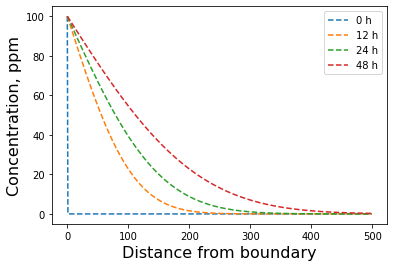

In [70]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from scipy.special import erfc

def diff(x,t,D,c0):
    """1D solution to Fick second law
    
    Parameters
    ----------
    x : distance in microns
    
    t : time in h
    
    D : diffusion coefficient in log10 m2 s-1
    
    c0 : concentration at the border in ppm
    
    Returns
    -------
    c : concentration at distance x
    """
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t*3600)))

x = np.arange(0,500,1.0) # Notre profil de la bordure au centre

x0 = 100.0 # ppm, la concentration en eau à la bordure

D = -13.1 # m2 s-1, le coefficient de diffusion à la température de travail, 1400 °C

plt.plot(x, diff(x,0.00001,D,100.0),"--",label="0 h")
plt.plot(x, diff(x,12,D,100.0),"--",label="12 h")
plt.plot(x, diff(x,24,D,100.0),"--",label="24 h")
plt.plot(x, diff(x,48,D,100.0),"--",label="48 h")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()

# Application to real-world data

You will find two files with concentrations in Al, Fe, Sc... measured by LA-ICP-MS after one experiments. Hit: conditions are in the filename...

Using the equation presented above, try to : 
- fit those data and determine the diffusion coefficients of those elements; 
- provide sensible errors bars for the parameters, and propagate them on the fit solution. 
- Re-do the above graph for all elements with errors bars

Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')
Index(['ElapsedTime_s', 'Distance', 'Si29_CPS', 'Mg_ppm_m25', 'Al_ppm_m27',
       'Sc_ppm_m45', 'Ti_ppm_m47', 'Fe_ppm_m57', 'Re_ppm_m185', 'Pt_ppm_m195'],
      dtype='object')


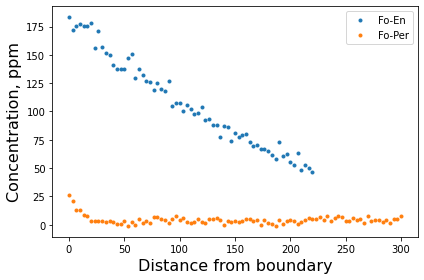

In [71]:
data_1400C_192h_FoEn = pd.read_csv("16C_ICP1_1400C_axisC_192h_FoEn.csv")
print(data_1400C_192h_FoEn.columns)
data_1400C_192h_FoPer = pd.read_csv("16B_ICP2_1400C_axisC_192h_FoPer.csv")
print(data_1400C_192h_FoPer.columns)

plt.plot(data_1400C_192h_FoEn.Distance,data_1400C_192h_FoEn.Fe_ppm_m57,".",label="Fo-En")
plt.plot(data_1400C_192h_FoPer.Distance,data_1400C_192h_FoPer.Fe_ppm_m57,".",label="Fo-Per")
plt.xlabel("Distance from boundary",fontsize=16)
plt.ylabel("Concentration, ppm",fontsize=16)
plt.legend()
plt.tight_layout()

t_exp = 192.0*3600
x_obs_1 = data_1400C_192h_FoEn.Distance
y_obs_1 = data_1400C_192h_FoEn.Fe_ppm_m57
ese_obs_1 = 7.0*np.ones(len(x_obs_1))

# Problem resolution

In [72]:
def forward_model(x,t,D,c0):
    """1D solution to Fick second law
    
    Parameters
    ----------
    x : distance in microns
    
    t : time in h
    
    D : diffusion coefficient in log10 m2 s-1
    
    c0 : concentration at the border in ppm
    
    Returns
    -------
    c : concentration at distance x
    """
    return c0*erfc(x*1e-6/(2*np.sqrt(10**D*t*3600)))
    
def lognormal(x,mu,std):
    var = std**2
    return -0.5*((x-mu)**2/var + np.log(2.0*np.pi*var))

def logprior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    D ,c0 = theta
    
    if -20 < D < 0 \
    and 0 < c0 < 200:
        return 0.0
    else:
        return -np.inf
    
def loglike(theta,x,t,y,yerr):
    """log likelyhood function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_likely : float
        the estimated likelyhood of the a model compared to observations
    
    """
    model = forward_model(x,t,*theta)
    ln_likely = np.sum(lognormal(y,model,yerr))
    return ln_likely

def logjoint(theta, x, t, y, yerr):
    """joint probability function
    
    This implementation uses the log of a gaussian distribution
    
    Parameters
    ==========
    theta : list
        the parameters
    x : ndarray
        the X variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
        
    Returns
    =======
    ln_prob : float
        the total likelyhood of a model compared to observations
    
    """
    lp = logprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglike(theta,x,t,y,yerr)

def mcmc(x,t,y,yerr,theta_start,scales,nb_iter):
    """MCMC Metropolis Hasting function to fit simple data
    
    Parameters
    ==========
    x : ndarray
        the distance variable
    t : ndarray
        the time variable
    y : ndarray
        the y observations
    yerr : ndarray
        the y errors
    theta_prior : list
        the estimates of model parameters
    scales : list
        scaling factor for perturbating the parameters
    nb_iter : int
        number of iterations to perform = number of sampled models
        
    Returns
    =======
    theta_record : ndarray, shape = (nb_iter,size(theta_prior))
        the estimates of model parameters
    logrecord : 1D array
        the log probabilities of the nb_iter models
    acceptance_rate : 1D array
        the acceptance rate for each parameter
        
    """
    logrecord = np.zeros(nb_iter)
    theta_record = np.zeros((nb_iter,len(theta_start)))
    
    # to calculated acceptance rate
    accepted = 0
    
    # the starting parameters and logrecord
    logrecord[0] = logjoint(theta_start,x,t,y,yerr)
    theta_record[0,:] = theta_start
    
    i = 1
    while i < nb_iter:
        
        # we perturbate parameters
        theta_0 = theta_record[i-1,:] + scales*np.random.randn(2)
        # we calculate the associated log prob
        logprob_theta0 = logjoint(theta_0,x,t,y,yerr)
        # and the ratio (subtraction as we are in log) with the old logprob
        alpha = logprob_theta0 - logrecord[i-1]
        
        if np.exp(alpha) > np.random.rand(): # if our probability is actually higher than the previous
            logrecord[i] = logprob_theta0
            theta_record[i,:] = theta_0
            accepted = accepted + 1
        else: # otherwise we stay at the same position
            logrecord[i] = logrecord[i-1]
            theta_record[i,:] = theta_record[i-1,:]
            
        i += 1 # incrementing i as well as the number of tested models
            
    # calculation of acceptance rates
    acceptance_rate = accepted/(nb_iter-1)
    
    # results are returned
    return theta_record, logrecord, acceptance_rate  

In [73]:
theta_start = [-13.0,150.0] # starting value of D and c0
if logprior(theta_start) == 0:
    print("Model viable")

Model viable


# Go to the top of the hill

In [74]:
# Find the maximum likelihood value.
import scipy.optimize as op

chi2 = lambda *args: -2 * logjoint(*args)
result = op.minimize(chi2, theta_start, args=(x_obs_1, t_exp, y_obs_1, ese_obs_1))
print(result)

      fun: 425.29309934111444
 hess_inv: array([[ 1.07477502e-04, -1.25490026e-03],
       [-1.25490026e-03,  3.68164769e-01]])
      jac: array([ 7.62939453e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 152
      nit: 11
     njev: 35
   status: 0
  success: True
        x: array([-17.10931485, 179.42142444])


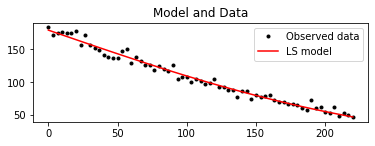

In [75]:
#Result is a dictionary, the best parameters are the x values.
popt = result['x'][:]

# we calculate the best estimate
y_pred_minimize = forward_model(x_obs_1, t_exp,*popt) # parameter unwrapping (*popt) works only in Python 3

plt.figure()

plt.subplot(2,1,1)
plt.plot(x_obs_1,y_obs_1,"k.",label="Observed data")
plt.plot(x_obs_1,y_pred_minimize,"r-",label="LS model")
plt.title("Model and Data")
plt.legend()


In [76]:
theta_start = result['x'] 

scales = [1e-1,1e-0]
scales_test = scales*np.random.randn(2)
print("Parameters starting value: "+str(theta_start)) 
print("Perturbations: "+str(scales_test))


Parameters starting value: [-17.10931485 179.42142444]
Perturbations: [0.05405165 0.79286466]


In [77]:
nb_iter= 30000
nb_chains = 3

chains_theta = []
chains_logrecord = []
chains_acceptance = []

for i in range(nb_chains):
    print("Running chain "+str(i))
    theta_mcmc, logrecord_mcmc, acceptance_rate = mcmc(x_obs_1, t_exp, y_obs_1,ese_obs_1,theta_start,scales,nb_iter)
    chains_theta.append(theta_mcmc)
    chains_logrecord.append(logrecord_mcmc)
    chains_acceptance.append(acceptance_rate)
    


Running chain 0
Running chain 1
Running chain 2


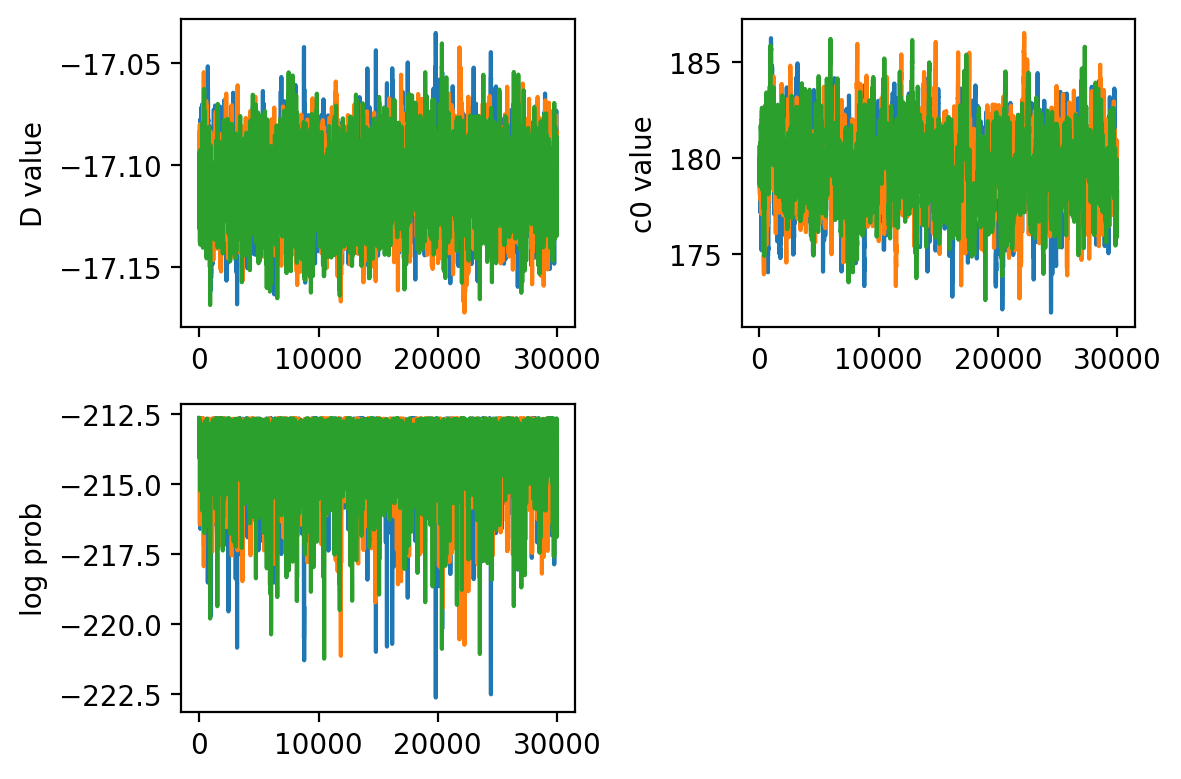

In [78]:
plt.figure(dpi=200)

plt.subplot(2,2,1)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,0])
plt.ylabel("D value")

plt.subplot(2,2,2)
for i in range(nb_chains):
    plt.plot(chains_theta[i][:,1])
plt.ylabel("c0 value")

plt.subplot(2,2,3)
for i in range(nb_chains):
    plt.plot(chains_logrecord[i])
plt.ylabel("log prob")


plt.tight_layout()

We check acceptance for each chain

In [79]:
print(chains_acceptance)

[0.1351711723724124, 0.13390446348211607, 0.13187106236874563]


In [80]:
Burnin = 5000
thin = 10

samples_MH=[]
for i in range(nb_chains):
    samples_MH.append(chains_theta[i][Burnin:thin:-1,:])
samples_MH = np.concatenate(samples_MH)

D_mcmc = np.median(samples_MH[:,0])
c0_mcmc = np.median(samples_MH[:,1])
nb_drawn_samples = len(samples_MH)

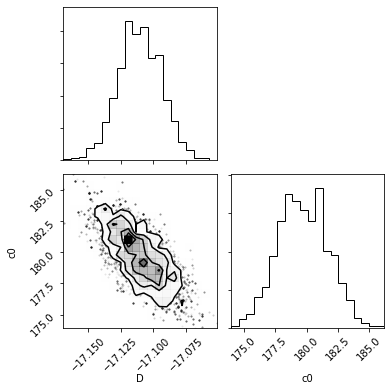

In [81]:
import corner
labels = ['D','c0']
fig_mh = corner.corner(samples_MH,labels=labels)
plt.tight_layout()

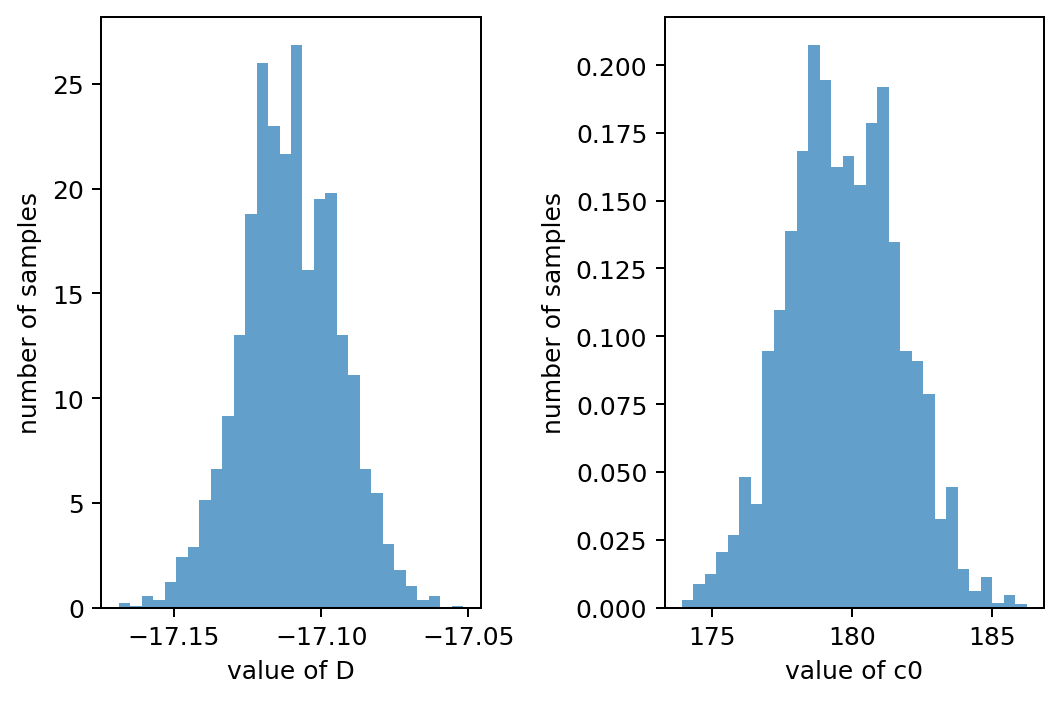

In [88]:
plt.figure(dpi=180)
plt.subplot(1,2,1)
plt.hist(samples_MH[:,0],
                 alpha=0.7,bins=30,density=True,label="MH")
plt.xlabel("value of D")
plt.ylabel("number of samples")

plt.subplot(1,2,2)
plt.hist(samples_MH[:,1],
                 alpha=0.7,bins=30,density=True)
plt.xlabel("value of c0")
plt.ylabel("number of samples")
plt.tight_layout()
plt.show()

We notice above that the distributions of D and c0 are slightly non-Gaussian. So here the sampling with MCMC is a good option to have a good idea of errors.

As we have many parameter samples, we can predict many models and see their position in the plot of distance versus observed concentration.

A high probability will be indicated by many models overlying. Visually, we can use the alpha option of matplotlib to set this up.

Text(0.5, 1.0, 'Model and Data')

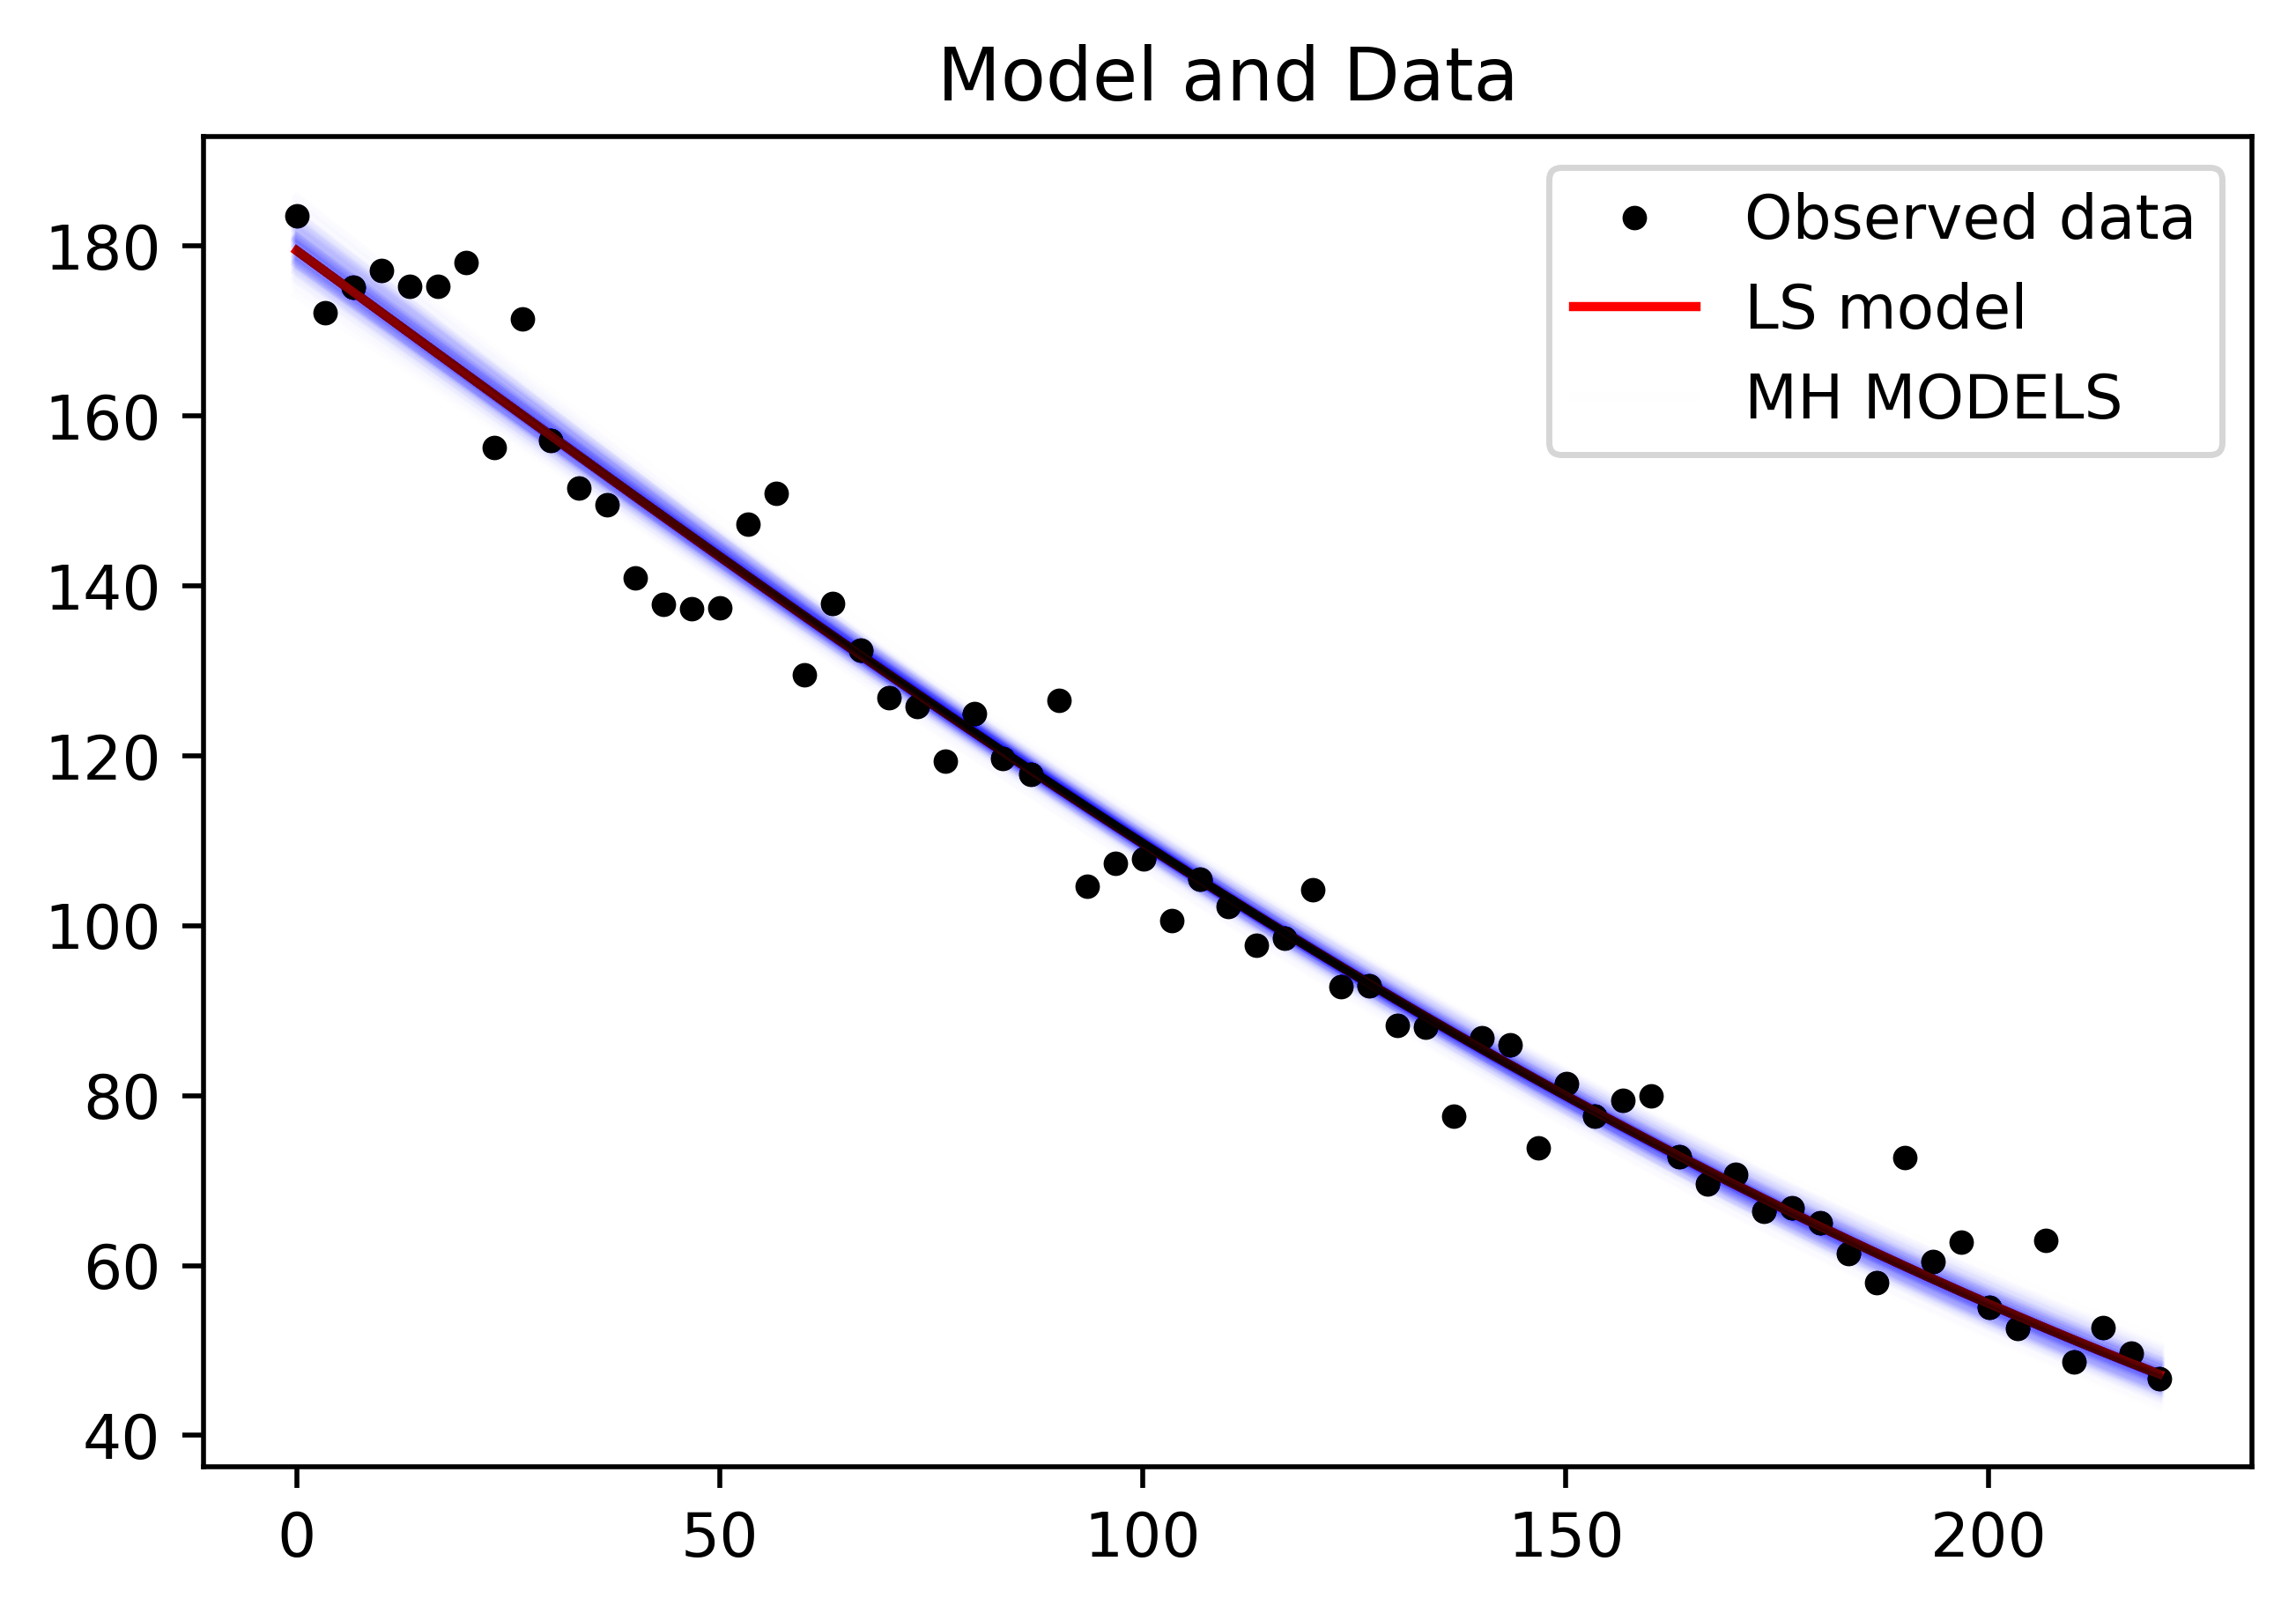

In [89]:
models = np.zeros((len(x_obs_1),500))

for i in range(500):
    gen_pick = np.random.randint(0,len(samples_MH))
    models[:,i] = forward_model(x_obs_1,t_exp,*samples_MH[gen_pick,:])

plt.figure(dpi=500)
plt.plot(x_obs_1,y_obs_1,"k.",label="Observed data")
plt.plot(x_obs_1,y_pred_minimize,"r-",label="LS model")
plt.plot(x_obs_1,models[:,0],"b-",alpha=0.005,label="MH MODELS")
plt.legend()
plt.plot(x_obs_1,models[:,1:],"b-",alpha=0.005,)
plt.title("Model and Data")

